## **Data Science Aplicado a las Finanzas** 🚀
### **Sesión 10: Aprendizaje Supervisado**

Andrés C. Medina Sanhueza

Senior Data Scientist Engineer 

anmedinas@gmail.com

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error
from matplotlib import pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
import yfinance as yf 
import warnings

warnings.simplefilter("ignore")
sns.set_style('dark')

## ⛈️ Introducción

El `Aprendizaje Automático` o `Machine Learning` es una disciplina del campo de la inteligencia artificial que, a través de algoritmos, dota a los ordenadores la capacidad de identificar patrones en datos masivos y elaborar predicciones mediante análisis predictivo. Este aprendizaje, permite a los computadores realizar tareas específicas de forma autónoma.

<img src="figs/ia_diagrama.png" width = 400 height = 400 />

En este contexto, los algoritmos `Machine Learning` se dividen en tres categorías, siendo las dos primeras las más comunes.

1. **`Aprendizaje No Supervisado`** estos algoritmos no cuentan con un conocimiento previo. Se enfrentan al caos de datos con el objetivo de encontrar patrones que permitan organizarlos de alguna manera.

2. **`Aprendizaje Supervisado`** estos algoritmos cuentan con un aprendizaje previo basado en un sistema de etiquetas asociadas a unos datos que les permiten tomar decisiones o hacer predicciones

3. **`Aprendizaje por Refuerzo`** su objetivo es que un algoritmo aprenda a partir de la propia experiencia. Esto es, que sea capaz de tomar la mejor decisión ante diferentes situaciones de acuerdo a un proceso de prueba y error en el que se recompensan las decisiones correctas

<img src="figs/task_ml.png" width = 600 height = 420 />

En cualquier Modelo de Aprendizaje Automático, el `Error de Predicción` puede ser separado en tres términos:

1. **`Varianza`** ¿ Qué tan factible es que cambia nuestra predicción si usamos otro set de datos?

2. **`Ruido`** error base imposible de reducir ya que se engloban variables desconocidas o no observables, problemas en la adiquisición de datos u otro.

3. **`Sesgo`** ¿ Qué tan lejana es nuestra predicción promedio con respecto al verdadero valor ?, esto se relaciona a las suposiciones o simplicidad del modelo

$$
\mathbb{E}_{x,y,\mathcal{D}} = \mathbb{E}_{x,\mathcal{D}}[(h_{\mathcal{D}}-\bar{h}(x))^2] + \mathbb{E}_{x,y}[(\bar{y}(x)-y)^2] + \mathbb{E}_{x}[(\bar{h}(x) - \bar{y}(x))^2]
$$

<img src="figs/low_bias.png" width = 800 height = 350 />

Es muy dificil construir un sólo modelo que obtenga un buen rendimiento (bajo sesgo y varianza), por tanto, en este contexto se procede a construir múltiples modelos `complejos` o `sencillos` con el mismo ó distinto set de datos y combinando sus predicciones. Por tanto, el objetivo es obtener un modelo final que tenga bajo error de sesgo y varianza. Ahora bien, entendamos lo siguiente: 

* `Modelo Complejo` Se considera un modelo complejo cuando se tiene bajo error de sesgo y alto error de varianza, por tanto la combinacion de predicciones producto un modelo que tiende a bajar la varianza de la prediccion. 

* `Modelo Sencillo` Se considera un modelo sencillo cuando se tiene alto error de sesgo y bajo error de varianza, por tanto la combinacion de predicciones mantendria un alto sesgo sin embargo, se enfocaria en los puntos mal clasificados.

### 🍁 Partición de Datos

Al momento de construir modelos de machine learning (aprendizaje supervisado o no supervisado), es necesario generar una partición de datos en conjuntos de `train`, `test` y en algunos casos, utilizan un tercer conjunto llamado `validation`. No obstante, para efectos de este curso, utilizaremos particiones  `train` y  `test` en proporciones de 70% y 30%. 

<img src="figs/train_test.png" width = 600 height = 350 />

La idea principal detrás de este mecanismo, es que simula cómo se comportará el modelo con datos que nunca ha visto, lo que ayuda en gran medida a evitar el problema de sobre ajuste u **`overfitting`**.  El concepto de `overfitting` significa que el modelo aprende patrones específicos del conjunto de entrenamiento en lugar de generalizar. En otras palabras, el modelo aprende de memoria patrones específicos de los datos y al momento de someterlo con un conjunto de datos diferentes, no es capaz de reconocerlos. 

<img src="figs/overfiting.png" width = 700 height = 350 />

📌 ¿ Cúal es el propósito del `Train` y `Test` ? 

* **`Train`**
    * Es el conjunto de datos utilizados para ajustar los parámetros del modelo
    * Aquií. el modelo aprende los patrones subyacentes de los datos 

* **`Test`**
    * Es un conjunto de datos no visto por el modelo durante el entrenamiento
    * Evalúa la capacidad del modelo para generalizar a datos nuevos 
    * Ayuda a medir métricas de rendimiento como precision, error absoluto o tasa de aciertos u otras métricas.

📌 ¿ Cúal es la diferencia de hacer Split de datos entre datos de corte transversal (enfoque tradicional) versus las series temporales ?

* `Split bajo enfoque Tradicional`
    * Se asume independencia entre los datos, esto significa que los datos de las muestras no estan correlacionados temporal o espacialmente.
    * La estrategia comun, es la division aleatoria. Esto quiere decir que los datos se dividen aleatoriamente. Tradicionalmente, se usa la funcion `train_test_split` de `Scikit-learn`
    * Ventajas. Proporciona una evaluacion confiable cuando no existe dependencia temporal.
    * Limitacion. No es aplicable a datos donde el orden importa, como las series temporales. 

* `Split bajo enfoque de Series de Tiempo`
    * Dependencia en el tiempo. En series temporales, los valores pasados influyen en los valores futuros.
    * Restriccion de causalidad. No puedes usar datos futuros para predecir el pasado o entrenar un modelo.
    * Estrategia, Division Secuencial. Los datos se dividen respetando el orden temporal:
        * Train : Datos mas antiguos 
        * Test : Datos mas recientes
    * Metodo comun : Validacion de Series Temporales mediante la funcion de `Scikit-learn`, `TimeSeriesSplit`
    * Ventaja. Simula como se comporta el modelo en datos futuros.
    * Limitacion. Requiere mas datos y puede ser sensibles a tendencias y estacionalidades.

In [2]:
# Ejemplo de Split con TimeSeriesSplit Dataset 
ticker = 'INTC'
df_int = yf.download(ticker, start = "2019-01-01", end = "2023-01-01", progress = False)
df_int.columns = df_int.columns.droplevel(1)
df_int['Returns'] = df_int['Close'].pct_change()
df_int = df_int.dropna()
df_int.head()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume,Returns
Date,,,,,,
2019-01-03,38.289040,39.829549,38.202976,39.717671,32267300,-0.055013
2019-01-04,40.638538,40.939754,39.192694,39.450880,35447300,0.061362
2019-01-07,40.827873,41.309822,40.234046,40.535262,22736800,0.004659
2019-01-08,41.086056,41.335633,40.259857,41.137691,22749200,0.006324
2019-01-09,41.318420,41.800369,41.120478,41.275390,22554500,0.005656


In [3]:
df_int.shape

(1007, 6)

In [4]:
df = df_int['Returns']

In [5]:
# Crea Train y Test Data bajo orden temporal
train = df.loc[df.index < "2021-12-01"]
test  = df.loc[df.index >= "2021-12-01"]
train.shape, test.shape

((734,), (273,))

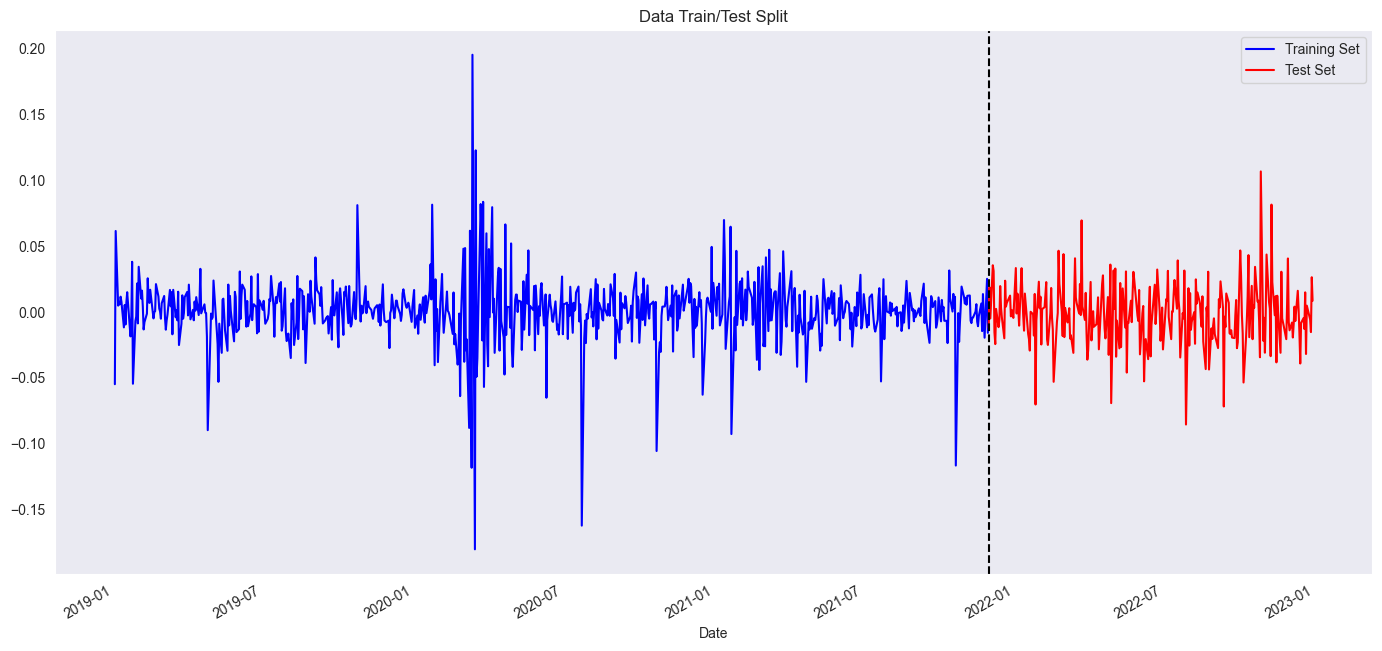

In [6]:
fig, ax = plt.subplots(figsize = (17, 8))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split', color = 'blue')
test.plot(ax = ax, label = 'Test Set', color = 'red')
ax.axvline('2021-12-01', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
from sklearn.model_selection import TimeSeriesSplit

Esta instrucción utiliza la clase TimeSeriesSplit de Scikit-Learn, que es una herramienta para dividir datos de series temporales en varios conjuntos de entrenamiento (train) y prueba (test)

In [8]:
tss = TimeSeriesSplit(n_splits = 5)
df = df.sort_index()

* `n_splits = 5` 
    * Especifica el número de particiones o divisiones que se crearán para la validación cruzada 
    * Cada división genera un conjunto de `train` y `test` respetando el orden cronológico
    * Con 5 divisiones, el modelo será evaluado 5 veces , cada vez usando un conjunto diferente de datos de `test`


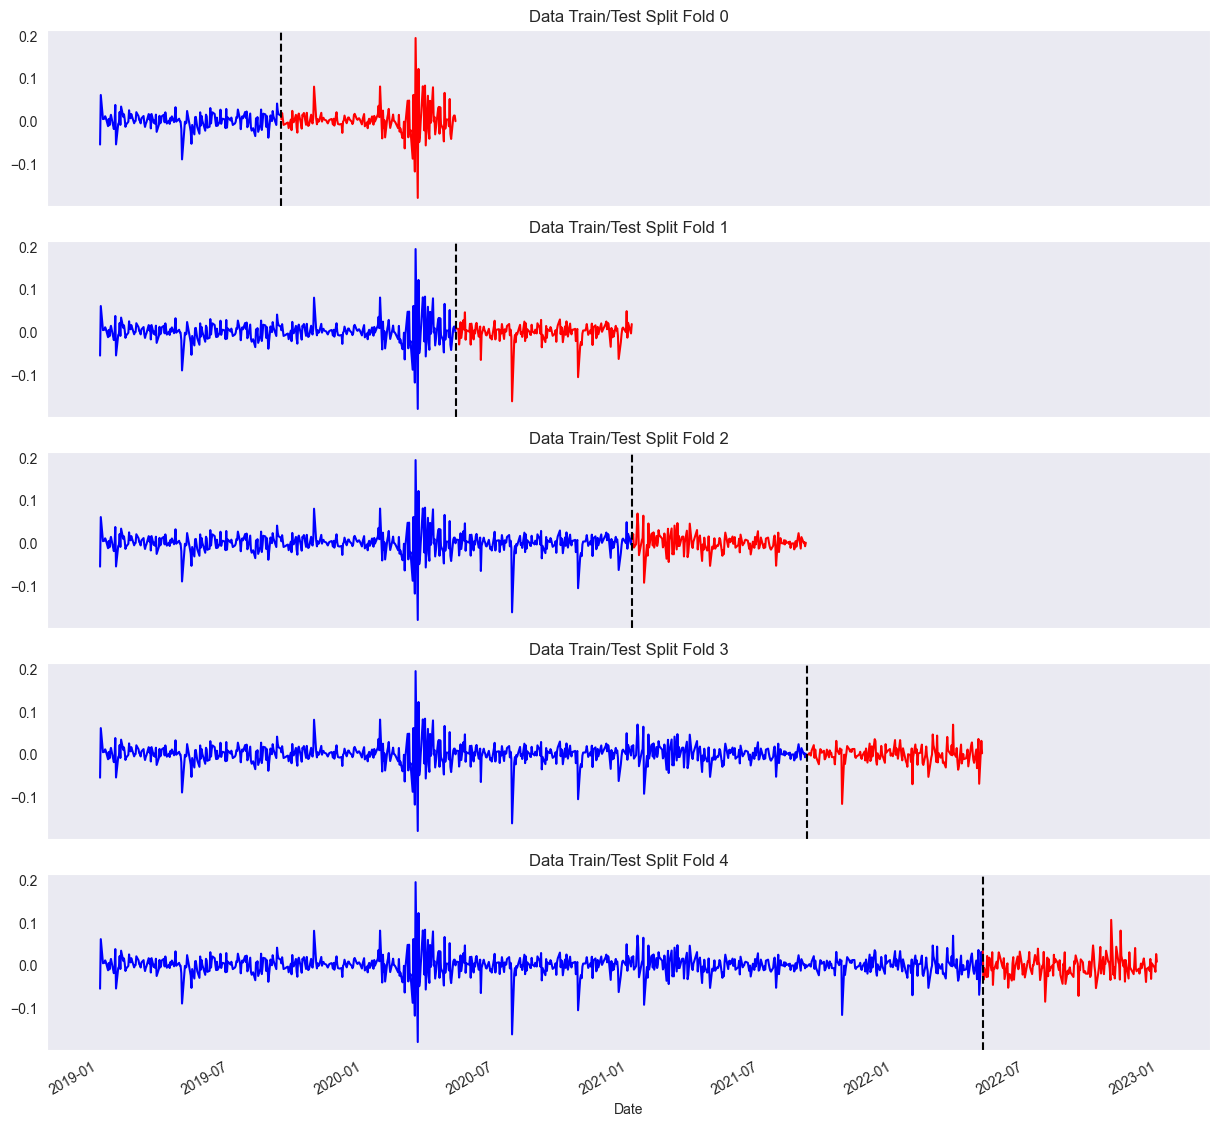

In [9]:
fig, axs = plt.subplots(5, 1, figsize = (15, 15), sharex = True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.plot(ax=axs[fold],
                          label = 'Training Set',
                          title = f'Data Train/Test Split Fold {fold}', color = 'blue')
    test.plot(ax = axs[fold],
                         label='Test Set', color = 'red')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### 🦊 Random Forest Regressor

En simple, `RandomForestRegressor` implementa un modelo de `Random Forest` para resolver un problema de regresión (`Random Forest` también resuelve problemas de clasificación). Basicamente, un modelo `Random Forest` es un método `ensemble` que combina múltiples árboles de decisión (entrenados con diferentes subconjuntos de datos) para realizar predicciones más precisas y robustas reduciendo el riesgo de sobreajuste. 


<img src="figs/rf_tree.jpg" width = 600 height = 400 />

📌 **`¿ Cómo funciona RandomForestRegressor()?`**

Lo hace mediante dos etapas. 

* `Construcción del Modelo`
    * Genera múltiples árboles de decisión 
    * Cada árbol se entrena usando un subconjunto aleatorio de datos y características (esto se conoce como `Bootsrap Sampling`)

* `Predicción`
    * Cada árbol individual genera una predicción 
    * La predicción final del `RandomForest` es el promedio de las predicciones de todos los árboles de decisión. Esto lo vuelve un método robusto frente a ruidos y reduce la varianza del modelo. 

Para invocar `RandomForestRegressor`, se hace mediante la siguiente instrucción. 

```python
from sklearn.ensemble import RandomForestRegressor
```

`RandomForestRegressor` tiene una familia de hiperparámetros que se dividen en tres grupos

* Hiperparámetros relacionados a `RandomForest`
    * `n_estimators` (default = `100`). Esto indica el número de árboles que se entrenaran. Un mayor número de árboles puede mejorar el rendimiento, pero aumenta el costo computacional.
    * `criterion` (default = `squared_error`). Esto indica la métrica para evaluar la calidad de una división en cada árbol. Existen otras opciones como `squared_error`, `absolute_error`.
    * `boostrap` (default = `True`). Si se debe usar bootstrap sampling al seleccionar subconjuntos de datos para cada árbol. Si es `True`, los datos para entrenar cada árbol se seleccionan con reemplazo.
    * `oob_score` (default = `False`). Si se debe calcular el error de predicción usando muestras out-of-bag (muestras no seleccionadas durante el bootstrap sampling). Este hiperparámetro es útil para validar el modelo sin un conjunto de validación separado.


* Hiperparámetros relacionados a los `Decision Tree` o Árboles de Decisión 
    * `max_depth` (default = `None`). Esto indica la profundidad máxima de los árboles. Mientras mas profundo el arbol generara mayor sobreajuste por tanto, limitar su profundidad puede evitar el sobreajuste. 
    * `min_samples_split` (default = `2`). Esto es el número mínimo de muestras requeridas para dividir un nodo. Valores más altos conducen a árboles más simples.
    * `min_samples_leaf` (default = `1`). Número mínimo de muestras que un nodo hoja debe tener. Esto, ayuda a controlar la complejidad del árbol.
    * `max_features` (default = `sqrt`). Número máximo de características consideradas para dividir en cada nodo. Existen otras opciones como: `auto`, `sqrt` que usa la raíz cuadrada del número total de características. `log2` que usa el logaritmo base 2 del número de características, o puede usar un numero entero o floatante que especifica un numero absoluto o fraccion.
    * `max_leaf_nodes` (default = `None`). Número máximo de nodos hoja permitidos. Limitarlo reduce la complejidad de los árboles.
    * `min_impurity_decrease`  (default = `0.0`). Una división se realiza solo si reduce la impureza total en al menos este valor. Controla la calidad de las divisiones.


* Hiperparámetros relacionados al `Performance`
    * `n_jobs` (default = `None`). Número de procesadores a usar en paralelo. El valor de -1 indica que se utiliza todos los núcleos disponibles.
    * `random_state` (default = `None`). Controla la aleatoriedad del modelo (e.g., selección de muestras y características).
    * `verbose` (default = `0`). Nivel de detalle durante el entrenamiento. Valores mayores a 0 aumentan la cantidad de mensajes.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error

In [11]:
# Descarga Serie de Precios de Tesla 
data = yf.download('TSLA', start = "2014-01-01", end = "2023-12-30", progress = False)
data.columns = data.columns.droplevel(1)

# Calculo de Retorno Logaritmico y Volatilidad Movil (Ventana a 30 dias)
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1) )
data['Volatility'] = data['Log_Return'].rolling(window = 30).std()

data.tail()

Price,Close,High,Low,Open,Volume,Log_Return,Volatility
Date,,,,,,,
2023-12-22,252.539993,258.220001,251.369995,256.760010,93370100,-0.007731,0.024146
2023-12-26,256.609985,257.970001,252.910004,254.490005,86892400,0.015988,0.024034
2023-12-27,261.440002,263.339996,257.519989,258.350006,106494400,0.018647,0.023226
2023-12-28,253.179993,265.130005,252.710007,263.660004,113619900,-0.032104,0.021824
2023-12-29,248.479996,255.190002,247.429993,255.100006,100891600,-0.018738,0.021793


In [12]:
# Generar rezagos para retornos y volatilidad
lags = 5
for lag in range(1, lags + 1):
    data[f'Lag_Return_{lag}'] = data['Log_Return'].shift(lag)
    data[f'Lag_Volatility_{lag}'] = data['Volatility'].shift(lag)

In [13]:
data.head()

Price,Close,High,Low,Open,Volume,Log_Return,Volatility,Lag_Return_1,Lag_Volatility_1,Lag_Return_2,Lag_Volatility_2,Lag_Return_3,Lag_Volatility_3,Lag_Return_4,Lag_Volatility_4,Lag_Return_5,Lag_Volatility_5
Date,,,,,,,,,,,,,,,,,
2014-01-02,10.006667,10.165333,9.770000,9.986667,92826000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,9.970667,10.146000,9.906667,10.000000,70425000,-0.003604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.800000,10.026667,9.682667,10.000000,80416500,-0.017265,NaN,-0.003604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,9.957333,10.026667,9.683333,9.841333,75511500,0.015927,NaN,-0.017265,NaN,-0.003604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,10.085333,10.246667,9.917333,9.923333,92448000,0.012773,NaN,0.015927,NaN,-0.017265,NaN,-0.003604,NaN,NaN,NaN,NaN,NaN


In [14]:
data = data.dropna() 

In [15]:
data.shape

(2481, 17)

In [16]:
# Variables predictoras y objetivo
X = data[[f'Lag_Return_{lag}' for lag in range(1, lags + 1)] + 
         [f'Lag_Volatility_{lag}' for lag in range(1, lags + 1)]].values

y = data['Volatility'].values

In [17]:
# TimeSeriesSplit para particion de datos 
tscv = TimeSeriesSplit(n_splits = 3, test_size = 365*2) # 2 años de test 

In [18]:
# Aplico el Modelo 
model = RandomForestRegressor(n_estimators = 100, random_state = 42)

cv_scores = cross_val_score(model, X, y, cv=tscv, scoring = 'neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)


In [19]:
# Entrenamiento final y predicción en la última partición
train_indices, test_indices = list(tscv.split(X))[-1]  # Última partición

In [20]:
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Métrica de evaluación RMSE
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.6f}")

Test RMSE: 0.043075


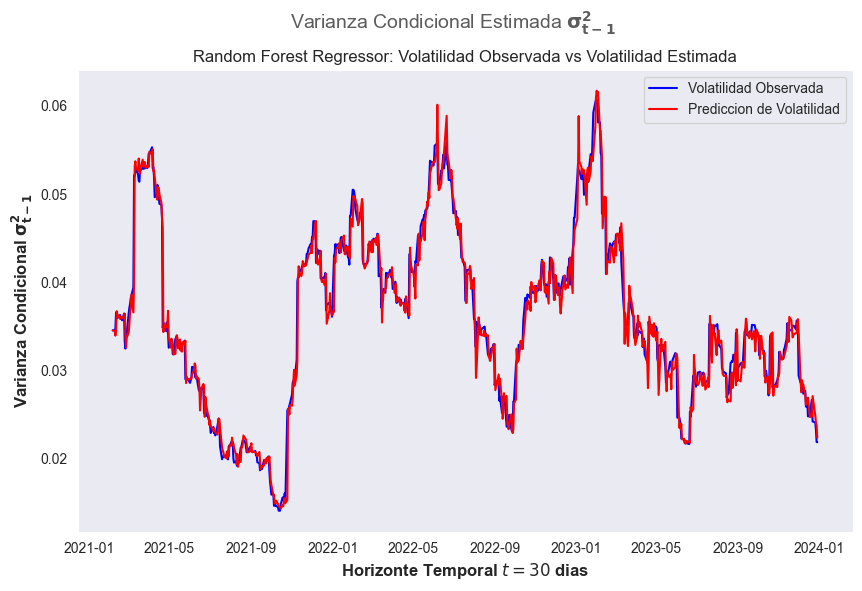

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label = "Volatilidad Observada", color = "blue")
plt.plot(data.index[-len(y_test):], y_pred, label = "Prediccion de Volatilidad", color = "red")
plt.suptitle(r"Varianza Condicional Estimada $\bf\sigma_{t-1}^2$", fontsize = 14, y = 0.98, alpha = 0.75)
plt.title("Random Forest Regressor: Volatilidad Observada vs Volatilidad Estimada")
plt.legend()
plt.xlabel(r"Horizonte Temporal $t = 30$ dias", fontsize = 12, fontweight = 'bold')
plt.ylabel(r"Varianza Condicional $\bf\sigma_{t-1}^2$", fontsize = 12, fontweight = 'bold')
plt.show()

In [22]:
print(f"Cross-Validation RMSE (mean): {cv_rmse.mean():.6f}")
print(f"Test RMSE: {rmse:.6f}")

Cross-Validation RMSE (mean): 0.005352
Test RMSE: 0.043075


In [23]:
# Funcion que genera proyección de volatilidad a 30 días
def forecast_volatility(model, last_known_data, days = 30, lags = 5):
    """
    Genera la proyeccion de volatilidad a t dias con k rezagos utilizando el modelo de 
    RandomForestRegressor 

    arguments:
        model : Modelo entrenado de RandomForestRegressor 
        last_known_data : Array que contiene los últimos valores conocidos de las variables predictoras 
                       (retornos y volatilidad rezagados). El tamaño debe ser lags * número de variables.

        days : Número de días a predecir (default = 30).
        lags : Número de rezagos utilizados en el modelo. 

    Return :
        predictions: Lista con las predicciones de volatilidad para los próximos 'days' días
    """

    # Lista que contendra las predicciones diarias 
    predictions = []

    # Usar los últimos datos conocidos como entrada inicial 
    # (debe incluir rezagos de retornos y volatilidad)
    current_input = last_known_data[-lags * 2:]  
    
    for _ in range(days):
        # Predecir la siguiente volatilidad con modelo de RandomForest Regressor 
        next_pred = model.predict(current_input.reshape(1, -1))[0]
        predictions.append(next_pred)
        
        # Actualizar la entrada: desplazar los rezagos e incluir la predicción
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_pred
    
    return predictions

In [24]:
# Obtener los últimos valores conocidos
last_known_data = X[-1]

# Predicción a 30 días
predicted_volatility = forecast_volatility(model, last_known_data, days = 30)
np.array(predicted_volatility)

array([0.02230827, 0.02351444, 0.02411814, 0.02464585, 0.02687726,
       0.02252281, 0.02320033, 0.02369579, 0.02474299, 0.02688561,
       0.02356363, 0.02331142, 0.02388306, 0.02478339, 0.02699339,
       0.02369602, 0.02349778, 0.02420011, 0.02474121, 0.02736188,
       0.02373589, 0.02340893, 0.02371893, 0.02476661, 0.02732455,
       0.0236775 , 0.02352622, 0.02384053, 0.02486876, 0.02688696])

### 🪼 Support Vector Regression (SVR)

`SVR` es una implementacion de regresion que utiliza máquinas de soporte vectorial (`SVM`) para encontar una función que mapea los datos de entrada a un espacio de características de mayor dimensión, permitiendo modelar relaciones no lineales entre las variables predictoras y la variable objetivo.  

<img src="figs/svm_svr.jpeg" width = 900 height = 300 />

Para utilizar esta función, se invoca desde `sklearn` como:

```python 
from sklearn.svm import SVR
```

Los hiperparámetros de este modelo, son los siguientes: 

* **`kernel`** Esto, define el tipo de nucleo o función de transformación utilizado para proyectar los datos en un espacio de dimensiones más altas, donde la regresión es más efectiva.
    * `linear` utiliza un núcleo lineal , útil cuando los datos tienen una relación lineal simple 
    * `poly` utiliza un núcleo polinomial, adecuado para datos que pueden ser modelados mediante una relación polinómica 
    * `rbf` radial basis function, el núcleo más común. Es ideal cuando las relaciones son complejas y no lineales
    * `sigmoid` utiliza función sigmoidea para transformar los datos


* **`C`** Controla la penalización de los errores. Es un parámetro de regularización que determina cuán estrictamente debe el modelo ajustarse a los datos de entrenamiento.
    * Generalmente, valores pequeños (como 0.1, 1) permiten que el modelo tenga mayor flexibilidad, mientras que valores altos (como 10, 100) fuerzan al modelo a ser más riguroso y penalizar los errores grandes.
    *  Si `C` es muy pequeño, el modelo puede subajustar (no aprender lo suficiente de los datos). Si es muy grande, puede sobreajustar (ajustar demasiado a los ruidos de los datos).

* **`epsilon`** Determina la tolerancia en el ajuste de la predicción. Especifica un margen dentro del cual los errores no se penalizan.
    * los valores típicos son sualmente entre 0.01 y 0.1
    * Un valor pequeño de `epsilon` fuerza al modelo a ajustar más de cerca a los datos (posible sobreajuste), mientras que un valor mayor permite una mayor flexibilidad, pero puede llevar a subajuste.

* **`degree`** (esto es valido solo si se usa `kernel = poly`) Define el grado del polinomio usado cuando se utiliza el núcleo polinómico.  Valores más altos hacen que el modelo sea más complejo, lo que podría llevar a sobreajuste si el conjunto de datos es pequeño o ruidoso.
 
* **`gamma`** Define la influencia de un solo punto de entrenamiento. Específicamente, en el caso de `kernel = rbf`, `gamma` controla cómo los puntos de datos individuales afectan la frontera de decisión.
    * El valor de `gamma` puede ser ajustado con técnicas de optimización, pero valores pequeños como 0.1 y 1 suelen ser útiles.
    * Un valor pequeño de `gamma` lleva a una decisión suave y puede subajustar el modelo. Un valor alto lleva a un modelo más rígido, lo que puede resultar en sobreajuste.

In [25]:
# Modulos Necesarios 
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error

In [26]:
# Descarga Serie de Precios de Tesla 
data = yf.download('TSLA', start = "2014-01-01", end = "2023-12-30", progress = False)
data.columns = data.columns.droplevel(1)

# Calculo de Retorno Logaritmico y Volatilidad Movil (Ventana a 30 dias)
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1) )
data['Volatility'] = data['Log_Return'].rolling(window = 30).std()

# Calcular volatilidad móvil (ventana de 30 días)
data['Volatility'] = data['Log_Return'].rolling(window=30).std()

# Crear rezagos de retornos y volatilidad
lags = 5
for lag in range(1, lags + 1):
    data[f'Lag_Return_{lag}'] = data['Log_Return'].shift(lag)
    data[f'Lag_Volatility_{lag}'] = data['Volatility'].shift(lag)

# Eliminar valores nulos
data = data.dropna()

# Variables predictoras y objetivo
X = data[[f'Lag_Return_{lag}' for lag in range(1, lags + 1)] + 
         [f'Lag_Volatility_{lag}' for lag in range(1, lags + 1)]].values
y = data['Volatility'].values

In [27]:
# Dividir los datos usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 3, test_size = 365*2)

# Ajusta el Modelo de Support Vector Regression 
model_svr = SVR(
    kernel = 'rbf', # Se usa el núcleo radial, adecuado para relaciones no lineales
    C = 1.0, # Regularización estándar, permitiendo un equilibrio entre ajuste y flexibilidad.
    epsilon = 0.01, # La tolerancia de ajuste es pequeña, lo que significa que se penalizan los errores más pequeños.
    gamma = 'scale' # Automáticamente ajusta el valor de gamma a 1 / (n_features * X.var()), una opción generalmente buena para muchos problemas.
    )

# Validación cruzada
cv_scores = cross_val_score(model, X, y, cv = tscv, scoring = 'neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE (mean): {cv_rmse.mean():.6f}")

Cross-Validation RMSE (mean): 0.005352


In [28]:
train_indices, test_indices = list(tscv.split(X))[-1]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

model_svr.fit(X_train, y_train)

y_pred = model_svr.predict(X_test)

# Métrica de evaluación RMSE
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.6f}")

Test RMSE: 0.067474


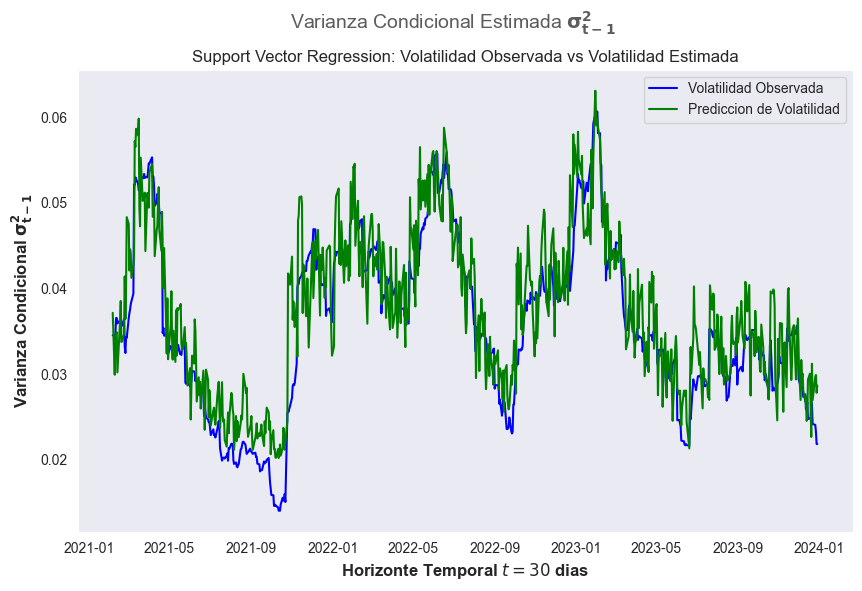

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label = "Volatilidad Observada", color = "blue")
plt.plot(data.index[-len(y_test):], y_pred, label = "Prediccion de Volatilidad", color = "green")
plt.suptitle(r"Varianza Condicional Estimada $\bf\sigma_{t-1}^2$", fontsize = 14, y = 0.98, alpha = 0.75)
plt.title("Support Vector Regression: Volatilidad Observada vs Volatilidad Estimada")
plt.legend()
plt.xlabel(r"Horizonte Temporal $t = 30$ dias", fontsize = 12, fontweight = 'bold')
plt.ylabel(r"Varianza Condicional $\bf\sigma_{t-1}^2$", fontsize = 12, fontweight = 'bold')
plt.show()

In [30]:
# Obtener los últimos valores conocidos
last_known_data = X[-1]

# Predicción a 30 días
predicted_volatility = forecast_volatility(model_svr, last_known_data, days = 30)
np.array(predicted_volatility)

array([0.02862117, 0.02385109, 0.02334835, 0.02644444, 0.02607475,
       0.02589639, 0.02534994, 0.02551768, 0.02635484, 0.02650974,
       0.02596884, 0.02576105, 0.02612865, 0.02638569, 0.02633289,
       0.02618321, 0.02620501, 0.02639333, 0.0264813 , 0.02641155,
       0.02636099, 0.02642263, 0.0265089 , 0.02652752, 0.02650137,
       0.02650476, 0.02655028, 0.02658686, 0.02658796, 0.02658168])